# Step response

Thermal Model Simulation.
This notebook simulates a simplified thermal model of a building using the `dm4bem` library in Python. It compares indoor the temperature evolution using both explicit and implicit Euler methods, with and without a controller when simulating a step response.

Importing the necessary Python libraries like numpy, pandas, matplotlib, and dm4bem

In [7]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import dm4bem


Model Setup. We neglected from the beginnning the glass capacity because we combined all the effects in the conductance of the window.

In [8]:
controller = False
neglect_air_glass_capacity = True 
imposed_time_step = False
Δt = 1800  # s,imposed time step

Load Thermal Circuit from CSV

The thermal circuit is loaded using the 'dm4bem.file2TC()' function, which reads a '.csv' file containing the thermal model elements, made in assignment 1.

If the 'controller' flag is set to 'True', we simulate an active control system by assigning a high thermal conductance value (1000 W/K). This represents strong and fast temperature regulation — similar to a thermostat — which ensures the room temperature closely follows the set point.

In [9]:
TC = dm4bem.file2TC('./MODEL/TC.csv', name='', auto_number=False)

if controller:
    TC['G']['q6'] = 1e3
    TC['G']['q14'] = 1e3


We can easily convert to State-Space and Determine Time Step

The thermal circuit model is converted to its state-space representationusing the 'dm4bem.tc2ss()' function, resulting in matrices 'As', 'Bs', 'Cs', and 'Ds', which describe the system's dynamics. 

The eigenvalues of matrix 'As' are used to calculate the maximum stable time step('Δtmax') for the explicit Euler method. This ensures numerical stability.

In [11]:
# Eigenvalues analysis
λ = np.linalg.eig(As)[0]        # eigenvalues of matrix As
# print(f'λ = {λ}')

# time step
Δtmax = 2 * min(-1 / λ)    # max time step for stability of Euler explicit
dm4bem.print_rounded_time('Δtmax', Δtmax)

if imposed_time_step:
    dt = Δt
else:
    dt = dm4bem.round_time(Δtmax)

if dt < 10:
    raise ValueError("Time step is too small. Stopping the script.")

dm4bem.print_rounded_time('dt', dt)

# settling time
t_settle = 4 * max(-1 / λ)
dm4bem.print_rounded_time('t_settle', t_settle)

# duration: next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
dm4bem.print_rounded_time('duration', duration)

Δtmax = 9273 s = 2.6 h
dt = 7200 s = 2.0 h
t_settle = 486028 s = 135.0 h
duration = 489600 s = 136.0 h


Now Generates input and time Vector

In this step, we create the input signals for the thermal model over the simulation period. Since we try to simulate a step response, we create an input vector with a step in the outdoor temperature. 

'To': Outdoor temperature is set to a constant step value of 10 °C.
'Ti1', 'Ti2': Indoor set point temperatures are both set to 20 °C.
'Φi1', 'Φi2', 'Φo1', 'Φo2': All solar radiation and auxiliary heating inputs are set to 0 (no heat gains/losses from solar or internal sources).

These arrays are then combined into a DataFrame 'input_data_set', with the simulation 'time' as the index. This will be used to feed the model with time-varying (or constant) boundary conditions.


In [12]:
# Create input_data_set u with constant values
# ---------------------
# time vector
n = int(np.floor(duration / dt))    # number of time steps

# DateTimeIndex starting at "00:00:00" with a time step of dt
time = pd.date_range(start="2025-01-01 00:00:00",
                           periods=n, freq=f"{int(dt)}s")
 
To = 10 * np.ones(n)         # outdoor temperature 10 °C
Ti1 = 20 * np.ones(n)        # indoor temperature set point 20 °C
Ti2 = 20 * np.ones(n)        # indoor temperature set point 20 °C
Φi1 = 0 * np.ones(n)         # solar radiation absorbed by the glass
Φo2 = Φo1 = Φi2 = Φi1        # auxiliary heat sources and solar radiation


data = {'To': To, 'Ti1': Ti1, 'To': To, 'Ti2': Ti2, 'To': To, 'Φo1': Φo1, 'Φi1': Φi1, 'Φi2': Φi2, 'Φo2': Φo2}
input_data_set = pd.DataFrame(data, index=time)

Time Integration (Euler) Computes indoor temperatures using explicit and implicit Euler methods.

In this step, we simulate how indoor temperatures evolve over time using two numerical methods:

-Explicit Euler: Calculates the next state directly using the current state.
-Implicit Euler: Uses the next state in the equation (requires solving a matrix inverse at each step).

We initialize both temperature dataframes ;θ_exp' and 'θ_imp' with zeros as the initial indoor temperature. Then, using a loop, we compute temperatures at each time step using the state-space matrices 'As' and 'Bs'.

The identity matrix 'I' is used to match the size of matrix 'As' for numerical operations.

The advantage of using a state space representation here is that we can immediately compute the two temperatures for room1 and room2 at the same time.

In [16]:
# inputs in time from input_data_set
u = dm4bem.inputs_in_time(us, input_data_set)

In [18]:
θ_exp = pd.DataFrame(index=u.index)
θ_imp = pd.DataFrame(index=u.index)

θ0 = 0.0 # initialisation: temperature of the rooms is 0°C before the step is applied
θ_exp[As.columns] = θ0
θ_imp[As.columns] = θ0

I = np.eye(As.shape[0])
for k in range(u.shape[0] - 1):
    θ_exp.iloc[k + 1] = (I + dt * As) @ θ_exp.iloc[k] + dt * Bs @ u.iloc[k]
    θ_imp.iloc[k + 1] = np.linalg.inv(I - dt * As) @ (θ_imp.iloc[k] + dt * Bs @ u.iloc[k])


Results and Plotting

This section visualizes the indoor temperatures computed by both explicit and implicit Euler methods.

-The output temperatures y_exp and y_imp are calculated using the state-space output equation:  
 nated into a single DataFrame y for easy plotting.

The graph displays the temperature evolution over time for Room 1 and Room 2, allowing comparison between both numerical methods. The plot title also shows the chosen and maximum allowable time step.


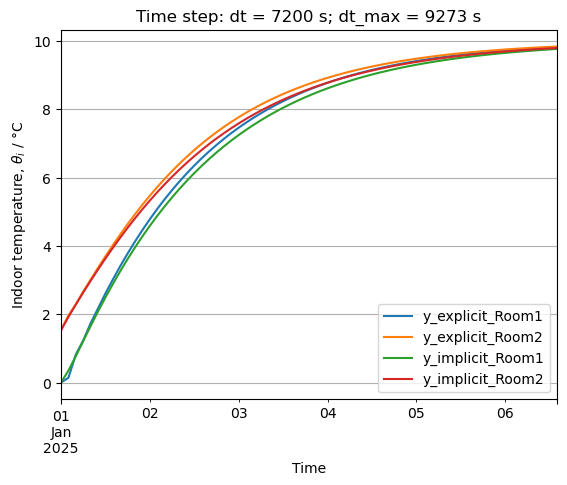

In [19]:
y_exp = (Cs @ θ_exp.T + Ds @ u.T).T
y_imp = (Cs @ θ_imp.T + Ds @ u.T).T

y = pd.concat([y_exp, y_imp], axis=1)
y.columns = ['y_explicit_Room1', 'y_explicit_Room2', 'y_implicit_Room1', 'y_implicit_Room2']

ax = y.plot()
ax.set_xlabel('Time')
ax.set_ylabel('Indoor temperature, $\\theta_i$ / °C')
ax.set_title(f'Time step: dt = {dt:.0f} s; dt_max = {Δtmax:.0f} s')
plt.grid()
plt.show()


We can remark here that Ds the direct matrix is not zero and therefore the temperature for room 2 does not start immediately at zero. In addition, the graph clearly shows a convergence to the outdoor temperature in time. If the controllers are set on (which can be done by the reader), the room temperatures will converge toward the setpoint temperatures. 

 Finally Steady-State Temperature Output

In [20]:
print("Steady-state indoor temperature:")
print(f"- Room 1: {y_exp.iloc[-1, 0]:.2f} °C")
print(f"- Room 2: {y_exp.iloc[-1, 1]:.2f} °C")
#TRY ALSO WITH THE CONTROLLER ON 


Steady-state indoor temperature:
- Room 1: 9.82 °C
- Room 2: 9.84 °C
